# Import

In [1]:
import os
os.chdir("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import catboost as cb
from sklearn.pipeline import Pipeline

In [4]:
from scr.util import *

# Base Infomation

In [5]:
df = pd.read_csv("data/train.csv")

In [6]:
df.shape

(3489, 18)

In [7]:
df.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   object 
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [9]:
df.describe()

,id,CityTier,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken
count,3489.000000,3489.000000,3489.000000,3456.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,1744.000000,1.697048,2.394669,7.765336,3.441101,0.102608,2.513901,0.142448
std,1007.331872,0.671500,0.726612,39.498670,0.599633,0.303490,1.115412,0.349559
min,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000
25%,872.000000,1.000000,2.000000,3.000000,3.000000,0.000000,2.000000,0.000000
50%,1744.000000,2.000000,2.000000,4.000000,3.000000,0.000000,2.000000,0.000000
75%,2616.000000,2.000000,3.000000,4.000000,4.000000,0.000000,3.000000,0.000000
max,3488.000000,3.000000,4.000000,600.000000,5.000000,1.000000,5.000000,1.000000


In [10]:
df.isna().sum()

id                          0
Age                       100
TypeofContact               6
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          33
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              22
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              56
customer_info               0
ProdTaken                   0
dtype: int64

In [11]:
tmp = ["TypeofContact", "Occupation", "Gender", "ProductPitched", "NumberOfTrips", "Designation", "customer_info"]
for column in tmp:
    print(column)
    print(df[column].unique(), "\n")

TypeofContact
['Self Enquiry' 'Company Invited' nan] 

Occupation
['Large Business' 'Salaried' 'Small Business'] 

Gender
['male' 'Male' 'Female' 'female' 'ｆｅｍａｌｅ' 'FEMALE' 'Ｍａｌｅ' 'Fe Male' 'MALE'
 'ｆｅ\u3000ｍａｌｅ' 'fe male' 'Ｆｅｍａｌｅ' 'ｍａｌｅ' 'FE MALE' 'Ｆｅ\u3000Ｍａｌｅ'
 'ＦＥＭＡＬＥ' 'ＦＥ\u3000ＭＡＬＥ' 'ＭＡＬＥ'] 

ProductPitched
['Basic' 'Standard' 'Super Deluxe' 'basic' 'SUPER DELUXE' 'super deluxe'
 'BASIC' 'Deluxe' 'deluxe' 'STANᗞARD' 'STANDARD' 'Вasic' 'DELUXE'
 'ꓢuper De|uxe' 'Ѕuper Deluxe' 'BAՏIC' 'Basıc' 'King' 'Super De|uxe'
 'king' 'standard' 'KING' 'BΑSIC' 'B𝖺sic' 'De|uxe' 'ᎠELUXE' 'Basiϲ'
 'de|u×e' 'Delu×e' 'Standar𝔡' 'Basi𝘤' 'Βasic' 'Տuper Deluxe' 'Staոdard'
 'BAꓢIC' 'ᗞeluxe' 'Տtandard' 'Βası𝘤' 'Kıng' 'Baｓic' 'basıc' 'super de|uxe'
 'Stand𝖺rd' 'S𝘵andard' '𐊡asic' 'St𝖺ndard' 'Super ᗞeluxe' 'de|uxe'
 'ｓuper deluxe' 'STANDARᎠ' 'Basiс' 'DΕLUXΕ' 'ꓢuper Deluxe' 'BASΙC'
 'ꓢtandard' 'В𝖺sic' 'Standa𝘳d' 'basiϲ' 'staոdard' 'Super Ꭰeluxe' 'DELUXΕ'
 'Ѕtandard' '𐊡asi𝘤' 'Ꭰeluxe' 'Kıոg' '𝙳eluxe' 'Kiոg' 'Βas

# Preprocessing

## NuLL

### Age -> age

In [12]:
df["Age"].unique()

array(['50歳', '56歳', nan, '三十七歳', '48歳', '19歳', '47歳', '49歳', '33歳',
       '３１歳', '51歳', '46歳', '４９歳', '53才', '20歳', '25歳', '五十三歳', '20代',
       '44歳', '30歳', '34歳', '29歳', '30代', '41歳', '50代', '52歳', '22歳',
       '３６歳', '28歳', '25才', '五十一歳', '48才', '38才', '三十三歳', '42際', '５０代',
       '35才', '59歳', '四十三歳', '32歳', '４２才', '53歳', '58歳', '40代', '二十六歳',
       '52際', '54歳', '59才', '29才', '21才', '57歳', '37歳', '35歳', '36才',
       '38歳', '３７歳', '50才', '51才', '43歳', '四十歳', '26歳', '31歳', '27歳',
       '40歳', '３４歳', '40際', '21歳', '24才', '45歳', '36歳', '41才', '38際',
       '18歳', '39歳', '４６歳', '４０代', '５５歳', '58際', '24歳', '41際', '三十一歳',
       '52才', '３０代', '28才', '55際', '60代', '27際', '３２歳', '60歳', '五十四歳',
       '29際', '三十四歳', '４７歳', '37際', '二十四歳', '四十七歳', '58才', '39才', '23才',
       '３３歳', '４２歳', '４５歳', '３９歳', '５４歳', '55歳', '42歳', '３８歳', '47才',
       '５１歳', '３９才', '51際', '二十七歳', '30才', '２６歳', '４０歳', '36際', '三十歳',
       '23歳', '二十二歳', '37才', '３０歳', '２８歳', '34才', '五十歳', '四十一歳', '５９歳',
       '

In [13]:
# 日本語をすべてInt型に変換
df["age"] = df["Age"].astype(str).apply(japanese_to_int)

# 欠損値を中央値で補完
# japanese_to_int関数により、欠損値は0と出力されている。
tmp = df[~(df["age"] == 0)]
df.loc[df["age"] == 0, "age"] = tmp["age"].median()

In [14]:
df["age"].unique()

array([50, 56, 38, 37, 48, 19, 47, 49, 33, 31, 51, 46, 53, 20, 25, 44, 30,
       34, 29, 41, 52, 22, 36, 28, 42, 35, 59, 43, 32, 58, 40, 26, 54, 21,
       57, 27, 24, 45, 18, 39, 55, 60, 23, 10, 61], dtype=int64)

### DurationOfPitch -> duration

In [15]:
df["DurationOfPitch"].unique()

array(['900秒', '14分', '10分', '1080秒', '1020秒', '16分', '840秒', '22分',
       '20分', '11分', '32分', '17分', '24分', '1380秒', '35分', '420秒', '5分',
       '480秒', '8分', '15分', '960秒', nan, '540秒', '26分', '13分', '12分',
       '21分', '25分', '720秒', '9分', '7分', '780秒', '6分', '18分', '31分',
       '600秒', '23分', '28分', '2160秒', '660秒', '1500秒', '1920秒', '27分',
       '33分', '360秒', '1320秒', '1740秒', '1680秒', '29分', '1620秒', '1440秒',
       '1800秒', '30分', '34分', '4分', '19分', '1860秒', '1260秒', '2100秒',
       '300秒', '2040秒', '1200秒', '1560秒', '1980秒', '36分', '1140秒'],
      dtype=object)

In [16]:
# 単位をすべて秒に統一
df["duration"] = df["DurationOfPitch"].dropna().apply(convert_to_second)

# 欠損値を中央値で補完
df["duration"] = df["duration"].fillna(df["duration"].median())

In [17]:
df["duration"].unique()

array([ 900.,  840.,  600., 1080., 1020.,  960., 1320., 1200.,  660.,
       1920., 1440., 1380., 2100.,  420.,  300.,  480.,  780.,  540.,
       1560.,  720., 1260., 1500.,  360., 1860., 1680., 2160., 1620.,
       1980., 1740., 1800., 2040.,  240., 1140.])

### TypeOfContact

In [18]:
# TypeofContact 後の処理のためにカラム名は変更しない

print(df['TypeofContact'].value_counts())

# 値の数が多い文字列で補完
df['TypeofContact'] = df['TypeofContact'].fillna('Self Enquiry')

TypeofContact
Self Enquiry       2194
Company Invited    1289
Name: count, dtype: int64


### NumnerOfFollowups

In [19]:
# 欠損値を中央値で補完
df['NumberOfFollowups'] = df['NumberOfFollowups'].fillna(df['NumberOfFollowups'].median())

### NumberPfTrips

In [20]:
tmp = df[~df['NumberOfTrips'].isna()]
tmp['NumberOfTrips'] = tmp['NumberOfTrips'].apply(normalize_trips)
df['NumberOfTrips'] = df['NumberOfTrips'].fillna(tmp['NumberOfTrips'].median())

C:\Users\ricke\AppData\Local\Temp\ipykernel_16668\3007596005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['NumberOfTrips'] = tmp['NumberOfTrips'].apply(normalize_trips)


### MonthlyIncome

In [21]:
tmp = df[~df['MonthlyIncome'].isna()]
tmp['MonthlyIncome'] = tmp['MonthlyIncome'].apply(normalize_monthly_income)
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(tmp['MonthlyIncome'].median())

C:\Users\ricke\AppData\Local\Temp\ipykernel_16668\103757898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['MonthlyIncome'] = tmp['MonthlyIncome'].apply(normalize_monthly_income)


In [22]:
df.isna().sum()

id                          0
Age                       100
TypeofContact               0
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
customer_info               0
ProdTaken                   0
age                         0
duration                    0
dtype: int64

In [23]:
df.shape

(3489, 20)

In [24]:
df.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,age,duration
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,50,900.0
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,56,840.0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,38,600.0
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,37,1080.0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1,48,1020.0


## Extract Features

In [25]:
df = df.drop(columns=["id", "Age", "DurationOfPitch"], axis=1)

In [26]:
df.shape

(3489, 17)

In [27]:
df.head()

,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,age,duration
0,Self Enquiry,2,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,50,900.0
1,Company Invited,1,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,56,840.0
2,Self Enquiry,1,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,38,600.0
3,Self Enquiry,2,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,37,1080.0
4,Company Invited,3,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1,48,1020.0


In [28]:
df.to_csv("data/middle/train_non_null.csv", index=False)

## Normalization

In [29]:
df = pd.read_csv("data/middle/train_non_null.csv")

In [30]:
df.shape

(3489, 17)

In [31]:
df.head()

,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,age,duration
0,Self Enquiry,2,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,50,900.0
1,Company Invited,1,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,56,840.0
2,Self Enquiry,1,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,38,600.0
3,Self Enquiry,2,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,37,1080.0
4,Company Invited,3,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1,48,1020.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TypeofContact           3489 non-null   object 
 1   CityTier                3489 non-null   int64  
 2   Occupation              3489 non-null   object 
 3   Gender                  3489 non-null   object 
 4   NumberOfPersonVisiting  3489 non-null   float64
 5   NumberOfFollowups       3489 non-null   float64
 6   ProductPitched          3489 non-null   object 
 7   PreferredPropertyStar   3489 non-null   float64
 8   NumberOfTrips           3489 non-null   object 
 9   Passport                3489 non-null   int64  
 10  PitchSatisfactionScore  3489 non-null   int64  
 11  Designation             3489 non-null   object 
 12  MonthlyIncome           3489 non-null   object 
 13  customer_info           3489 non-null   object 
 14  ProdTaken               3489 non-null   

In [33]:
tmp = ["TypeofContact", "CityTier", "Occupation", "Gender", "NumberOfTrips", "customer_info", "ProductPitched", "Designation"]
for column in tmp:
    print(column)
    print(df[column].unique(), "\n")

TypeofContact
['Self Enquiry' 'Company Invited'] 

CityTier
[2 1 3] 

Occupation
['Large Business' 'Salaried' 'Small Business'] 

Gender
['male' 'Male' 'Female' 'female' 'ｆｅｍａｌｅ' 'FEMALE' 'Ｍａｌｅ' 'Fe Male' 'MALE'
 'ｆｅ\u3000ｍａｌｅ' 'fe male' 'Ｆｅｍａｌｅ' 'ｍａｌｅ' 'FE MALE' 'Ｆｅ\u3000Ｍａｌｅ'
 'ＦＥＭＡＬＥ' 'ＦＥ\u3000ＭＡＬＥ' 'ＭＡＬＥ'] 

NumberOfTrips
['5' '2' '4' '1' '年に1回' '年に2回' '年に6回' '3' '年に5回' '7' '6' '半年に1回' '年に4回'
 '年に3回' '8' '年に8回' '3.0' '年に7回' '四半期に1回'] 

customer_info
['未婚 車未所持 子供なし' '離婚済み,車あり,子供無し' '結婚済み、自動車未所有,子供なし' ...
 '結婚済み,車保有なし,子供有り 1人' '結婚済み/自家用車なし/1児' '独身／車所持／こども1人'] 

ProductPitched
['Basic' 'Standard' 'Super Deluxe' 'basic' 'SUPER DELUXE' 'super deluxe'
 'BASIC' 'Deluxe' 'deluxe' 'STANᗞARD' 'STANDARD' 'Вasic' 'DELUXE'
 'ꓢuper De|uxe' 'Ѕuper Deluxe' 'BAՏIC' 'Basıc' 'King' 'Super De|uxe'
 'king' 'standard' 'KING' 'BΑSIC' 'B𝖺sic' 'De|uxe' 'ᎠELUXE' 'Basiϲ'
 'de|u×e' 'Delu×e' 'Standar𝔡' 'Basi𝘤' 'Βasic' 'Տuper Deluxe' 'Staոdard'
 'BAꓢIC' 'ᗞeluxe' 'Տtandard' 'Βası𝘤' 'Kıng' 'Baｓic' 'basıc' 'super 

### Gender -> gender

In [34]:
df['Gender'].unique()

array(['male', 'Male', 'Female', 'female', 'ｆｅｍａｌｅ', 'FEMALE', 'Ｍａｌｅ',
       'Fe Male', 'MALE', 'ｆｅ\u3000ｍａｌｅ', 'fe male', 'Ｆｅｍａｌｅ', 'ｍａｌｅ',
       'FE MALE', 'Ｆｅ\u3000Ｍａｌｅ', 'ＦＥＭＡＬＥ', 'ＦＥ\u3000ＭＡＬＥ', 'ＭＡＬＥ'],
      dtype=object)

In [35]:
df['gender'] = df['Gender'].apply(normalize_gender)

In [36]:
df['gender'].unique()

array(['male', 'female'], dtype=object)

### NumberOfFollowups -> follow

In [37]:
df['NumberOfFollowups'].value_counts()

NumberOfFollowups
4.0      1429
3.0      1279
5.0       519
2.0       108
1.0        77
6.0        38
300.0      17
400.0      15
500.0       5
100.0       1
600.0       1
Name: count, dtype: int64

In [38]:
df['follow'] = df['NumberOfFollowups'].apply(lambda x: x if x < 100 else x / 100)

In [39]:
df['follow'].value_counts()

follow
4.0    1444
3.0    1296
5.0     524
2.0     108
1.0      78
6.0      39
Name: count, dtype: int64

### ProductPitched -> product_pitched

In [40]:
df['ProductPitched'].unique()

array(['Basic', 'Standard', 'Super Deluxe', 'basic', 'SUPER DELUXE',
       'super deluxe', 'BASIC', 'Deluxe', 'deluxe', 'STANᗞARD',
       'STANDARD', 'Вasic', 'DELUXE', 'ꓢuper De|uxe', 'Ѕuper Deluxe',
       'BAՏIC', 'Basıc', 'King', 'Super De|uxe', 'king', 'standard',
       'KING', 'BΑSIC', 'B𝖺sic', 'De|uxe', 'ᎠELUXE', 'Basiϲ', 'de|u×e',
       'Delu×e', 'Standar𝔡', 'Basi𝘤', 'Βasic', 'Տuper Deluxe', 'Staոdard',
       'BAꓢIC', 'ᗞeluxe', 'Տtandard', 'Βası𝘤', 'Kıng', 'Baｓic', 'basıc',
       'super de|uxe', 'Stand𝖺rd', 'S𝘵andard', '𐊡asic', 'St𝖺ndard',
       'Super ᗞeluxe', 'de|uxe', 'ｓuper deluxe', 'STANDARᎠ', 'Basiс',
       'DΕLUXΕ', 'ꓢuper Deluxe', 'BASΙC', 'ꓢtandard', 'В𝖺sic', 'Standa𝘳d',
       'basiϲ', 'staոdard', 'Super Ꭰeluxe', 'DELUXΕ', 'Ѕtandard', '𐊡asi𝘤',
       'Ꭰeluxe', 'Kıոg', '𝙳eluxe', 'Kiոg', 'Βasıc', 'BASIС',
       'SUPER DΕLUXE', 'B𝖺si𝘤', 'ΒASIС', 'Super 𝙳eluxe', 'Տtanda𝘳d',
       'Basıϲ', 'ЅTANDARD'], dtype=object)

In [41]:
df['product_pitched'] = df['ProductPitched'].apply(normalize_product_pitched_1)

In [42]:
df['product_pitched'].unique()

array(['Basic', 'Standard', 'Deluxe', 'super deiuxe', 'banic', 'King',
       'deiuxe', 'seluxe', 'basis', 'ntandard', 'iasic', 'standars',
       'basιc', 'super seluxe', 'ѕtandard'], dtype=object)

In [43]:
df['product_pitched'] = df['product_pitched'].apply(normalize_product_pitched_2)

In [44]:
df['product_pitched'].unique()

array(['Basic', 'Standard', 'Deluxe', 'Super Deluxe', 'King'],
      dtype=object)

### NumberOfTrips -> trip_per_year

In [45]:
df['NumberOfTrips'].unique()

array(['5', '2', '4', '1', '年に1回', '年に2回', '年に6回', '3', '年に5回', '7', '6',
       '半年に1回', '年に4回', '年に3回', '8', '年に8回', '3.0', '年に7回', '四半期に1回'],
      dtype=object)

In [46]:
df['trip_per_year'] = df['NumberOfTrips'].apply(normalize_trips)

In [47]:
df['trip_per_year'].unique()

array([5, 2, 4, 1, 8, 24, 3, 20, 7, 6, 16, 12, 32, '3.0', 28],
      dtype=object)

### Designation -> designation

In [48]:
df['Designation'].unique()

array(['Executive', 'Senior Manager', 'AVP', 'Manager', 'Senior Manage𝙧',
       'Execuｔive', 'Μanager', 'VP', 'Sеnior Manager', 'ΑVP', 'АVP',
       'E×ecutive', 'Mαnage𝙧', 'Executiѵе', 'Ѕenior Manager', 'Managеr',
       'Еxecutivе', 'Senior Μanαger', 'Еxecuｔive', 'Exеcutivе',
       'Exеcutive', 'Senior Managе𝙧', 'Manage𝙧', 'Senio𝙧 Manager',
       'Manαger', 'Μanage𝙧', 'Manαgеr', 'Senior Managеr', 'Executivе',
       'Executiѵe', 'Е×еcutive', 'Еxecutive', 'VＰ', 'Տenior Μanager',
       'Exеcutiѵе', 'Senior Manαger', 'Mαnager', 'Senior Mαnαger',
       'E×еcutiѵe', 'Ѕenior Manαger', 'Exеcｕtive', 'Execｕtive', 'Mαnαger',
       'Μanagеr', 'E×ecｕtive', 'Sеnior Managеr', 'Տenior Manager', 'AVＰ',
       'Exеcｕtivе', 'Mαnagеr', 'Еxеcutivе', 'Senior Mαnager', 'Е×ecutive'],
      dtype=object)

In [49]:
df['designation'] = df['Designation'].apply(normalize_designation_1)

In [50]:
df['designation'].unique()

array(['Executive', 'Senior Manager', 'AVP', 'Manager', 'μanager', 'VP',
       'e×ecutive', 'senior μanager'], dtype=object)

In [51]:
df['designation'] = df['designation'].apply(normalize_designation_2)

In [52]:
df['designation'].unique()

array(['Executive', 'Senior Manager', 'AVP', 'Manager', 'VP'],
      dtype=object)

### MonthlyIncome -> income

In [53]:
df['MonthlyIncome'].unique()

array(['253905.0', '404475.0', '278145.0', ..., '317340.0', '527910.0',
       '278190.0'], dtype=object)

In [54]:
df['income'] = df['MonthlyIncome'].apply(normalize_monthly_income)

In [55]:
df['income'].unique()

array([253905., 404475., 278145., ..., 317340., 527910., 278190.])

### customer_info -> info_1, info_2, info_3

In [56]:
df[['info_1', 'info_2', 'info_3']] = df['customer_info'].apply(divide_customer_info)

In [57]:
df[['info_1', 'info_2', 'info_3']].head()

,info_1,info_2,info_3
0,未婚,車未所持,子供なし
1,離婚済み,車あり,子供無し
2,結婚済み,自動車未所有,子供なし
3,離婚済み,車所持,子供無し
4,独身,車所持,無子


In [58]:
print('NuLL (info_1) : ', df['info_1'].isna().sum())
print('NuLL (info_2) : ', df['info_2'].isna().sum())
print('NuLL (info_3) : ', df['info_3'].isna().sum())

NuLL (info_1) :  0
NuLL (info_2) :  0
NuLL (info_3) :  0


In [59]:
print('info_1 unique : ', df['info_1'].unique(), '\n')
print('info_2 unique : ', df['info_2'].unique(), '\n')
print('info_3 unique : ', df['info_3'].unique())

info_1 unique :  ['未婚' '離婚済み' '結婚済み' '独身'] 

info_2 unique :  ['車未所持' '車あり' '自動車未所有' '車所持' '自家用車あり' '車保有' '車保有なし' '乗用車所持' '乗用車なし'
 '自動車所有' '自家用車なし' '車なし'] 

info_3 unique :  ['子供なし' '子供無し' '無子' '子供ゼロ' '非育児家庭' '子育て状況不明' '子の数不詳' '子供の数不明' 'こども1人' '1児'
 '子供1人' '子供有り(1人)' 'わからない' '子供有り' 'こども2人' '子供2人' '子供有り(2人)' 'こども3人' '子供3人'
 '不明' '2児' '3児' '子供有り(3人)']


In [60]:
df['info_1'] = df['info_1'].apply(normalize_info_1)
df['info_2'] = df['info_2'].apply(normalize_info_2)
df['info_3'] = df['info_3'].apply(normalize_info_3)

In [61]:
print('info_1 unique : ', df['info_1'].unique(), '\n')
print('info_2 unique : ', df['info_2'].unique(), '\n')
print('info_3 unique : ', df['info_3'].unique())

info_1 unique :  ['Single' 'Divorced' 'Married'] 

info_2 unique :  ['No Car' 'Has Car'] 

info_3 unique :  ['0' '1' '2' '3']


### Confirm

In [62]:
df['trip_per_year'] = df['trip_per_year'].astype('float')
df['trip_per_year'] = df['trip_per_year'].astype('int')

tmp = ["gender", "product_pitched", "trip_per_year", "designation", "info_1", "info_2", "info_3"]
for column in tmp:
    print(column)
    print(df[column].unique(), "\n")

gender
['male' 'female'] 

product_pitched
['Basic' 'Standard' 'Deluxe' 'Super Deluxe' 'King'] 

trip_per_year
[ 5  2  4  1  8 24  3 20  7  6 16 12 32 28] 

designation
['Executive' 'Senior Manager' 'AVP' 'Manager' 'VP'] 

info_1
['Single' 'Divorced' 'Married'] 

info_2
['No Car' 'Has Car'] 

info_3
['0' '1' '2' '3'] 



### Output CSV

In [63]:
df.shape

(3489, 26)

In [64]:
df = df.drop(columns=['Gender', 'NumberOfFollowups', 'ProductPitched', 'NumberOfTrips', 'Designation', 'customer_info','MonthlyIncome'])

In [65]:
df.shape

(3489, 19)

In [66]:
df.head()

,TypeofContact,CityTier,Occupation,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,gender,follow,product_pitched,trip_per_year,designation,income,info_1,info_2,info_3
0,Self Enquiry,2,Large Business,1.0,3.0,1,4,1,50,900.0,male,4.0,Basic,5,Executive,253905.0,Single,No Car,0
1,Company Invited,1,Salaried,1.0,3.0,1,4,0,56,840.0,male,4.0,Standard,2,Senior Manager,404475.0,Divorced,Has Car,0
2,Self Enquiry,1,Large Business,1.0,3.0,0,4,1,38,600.0,female,3.0,Basic,4,Executive,278145.0,Married,No Car,0
3,Self Enquiry,2,Small Business,1.0,4.0,0,5,0,37,1080.0,female,3.0,Standard,1,Senior Manager,326805.0,Divorced,Has Car,0
4,Company Invited,3,Small Business,1.0,4.0,0,4,1,48,1020.0,female,3.0,Basic,4,Executive,258435.0,Single,Has Car,0


In [67]:
df.to_csv('data/middle/train_normalized.csv', index=False)

## Data Type

In [68]:
df = pd.read_csv('data/middle/train_normalized.csv')

In [69]:
df.shape

(3489, 19)

In [70]:
df.head()

,TypeofContact,CityTier,Occupation,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,gender,follow,product_pitched,trip_per_year,designation,income,info_1,info_2,info_3
0,Self Enquiry,2,Large Business,1.0,3.0,1,4,1,50,900.0,male,4.0,Basic,5,Executive,253905.0,Single,No Car,0
1,Company Invited,1,Salaried,1.0,3.0,1,4,0,56,840.0,male,4.0,Standard,2,Senior Manager,404475.0,Divorced,Has Car,0
2,Self Enquiry,1,Large Business,1.0,3.0,0,4,1,38,600.0,female,3.0,Basic,4,Executive,278145.0,Married,No Car,0
3,Self Enquiry,2,Small Business,1.0,4.0,0,5,0,37,1080.0,female,3.0,Standard,1,Senior Manager,326805.0,Divorced,Has Car,0
4,Company Invited,3,Small Business,1.0,4.0,0,4,1,48,1020.0,female,3.0,Basic,4,Executive,258435.0,Single,Has Car,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TypeofContact           3489 non-null   object 
 1   CityTier                3489 non-null   int64  
 2   Occupation              3489 non-null   object 
 3   NumberOfPersonVisiting  3489 non-null   float64
 4   PreferredPropertyStar   3489 non-null   float64
 5   Passport                3489 non-null   int64  
 6   PitchSatisfactionScore  3489 non-null   int64  
 7   ProdTaken               3489 non-null   int64  
 8   age                     3489 non-null   int64  
 9   duration                3489 non-null   float64
 10  gender                  3489 non-null   object 
 11  follow                  3489 non-null   float64
 12  product_pitched         3489 non-null   object 
 13  trip_per_year           3489 non-null   int64  
 14  designation             3489 non-null   

In [72]:
# not necessary to convert dtypes
# [CityTier, Passport, age, duration, trip_per_year]
int_columns = ['NumberOfPersonVisiting', 'PreferredPropertyStar', 'follow']
category_columns = ['TypeofContact', 'Occupation', 'gender', 'product_pitched', 'designation', 'info_1', 'info_2', 'info_3']

for col in int_columns:
    df[col] = df[col].astype('int')

for col in category_columns:
    df[col] = df[col].astype('category')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   TypeofContact           3489 non-null   category
 1   CityTier                3489 non-null   int64   
 2   Occupation              3489 non-null   category
 3   NumberOfPersonVisiting  3489 non-null   int32   
 4   PreferredPropertyStar   3489 non-null   int32   
 5   Passport                3489 non-null   int64   
 6   PitchSatisfactionScore  3489 non-null   int64   
 7   ProdTaken               3489 non-null   int64   
 8   age                     3489 non-null   int64   
 9   duration                3489 non-null   float64 
 10  gender                  3489 non-null   category
 11  follow                  3489 non-null   int32   
 12  product_pitched         3489 non-null   category
 13  trip_per_year           3489 non-null   int64   
 14  designation             

In [74]:
df.to_csv('data/middle/train_categorized.csv', index=False)

## One-Hot-Encoding

In [75]:
df = pd.read_csv('data/middle/train_categorized.csv')

category_columns = ['TypeofContact', 'Occupation', 'gender', 'product_pitched', 'designation', 'info_1', 'info_2', 'info_3']
for col in category_columns:
    df[col] = df[col].astype('category')

In [76]:
df.shape

(3489, 19)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   TypeofContact           3489 non-null   category
 1   CityTier                3489 non-null   int64   
 2   Occupation              3489 non-null   category
 3   NumberOfPersonVisiting  3489 non-null   int64   
 4   PreferredPropertyStar   3489 non-null   int64   
 5   Passport                3489 non-null   int64   
 6   PitchSatisfactionScore  3489 non-null   int64   
 7   ProdTaken               3489 non-null   int64   
 8   age                     3489 non-null   int64   
 9   duration                3489 non-null   float64 
 10  gender                  3489 non-null   category
 11  follow                  3489 non-null   int64   
 12  product_pitched         3489 non-null   category
 13  trip_per_year           3489 non-null   int64   
 14  designation             

In [78]:
df.describe()

,CityTier,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,follow,trip_per_year,income
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,1.697048,2.394669,3.441101,0.102608,2.513901,0.142448,38.864431,857.884781,3.672112,4.542849,355470.235024
std,0.671500,0.726612,0.599633,0.303490,1.115412,0.349559,9.842464,410.226215,0.885487,4.613311,74583.988839
min,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000,10.000000,240.000000,1.000000,1.000000,200000.000000
25%,1.000000,2.000000,3.000000,0.000000,2.000000,0.000000,31.000000,540.000000,3.000000,2.000000,300435.000000
50%,2.000000,2.000000,3.000000,0.000000,2.000000,0.000000,38.000000,780.000000,4.000000,3.000000,343140.000000
75%,2.000000,3.000000,4.000000,0.000000,3.000000,0.000000,47.000000,960.000000,4.000000,5.000000,400000.000000
max,3.000000,4.000000,5.000000,1.000000,5.000000,1.000000,61.000000,2160.000000,6.000000,32.000000,600000.000000


In [79]:
print(len(df.columns))
print(df.columns)

19
Index(['TypeofContact', 'CityTier', 'Occupation', 'NumberOfPersonVisiting',
       'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore',
       'ProdTaken', 'age', 'duration', 'gender', 'follow', 'product_pitched',
       'trip_per_year', 'designation', 'income', 'info_1', 'info_2', 'info_3'],
      dtype='object')


In [80]:
df_one_hot_encoded = pd.get_dummies(df, dtype=int)

print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

37
Index(['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'age', 'duration',
       'follow', 'trip_per_year', 'income', 'TypeofContact_Company Invited',
       'TypeofContact_Self Enquiry', 'Occupation_Large Business',
       'Occupation_Salaried', 'Occupation_Small Business', 'gender_female',
       'gender_male', 'product_pitched_Basic', 'product_pitched_Deluxe',
       'product_pitched_King', 'product_pitched_Standard',
       'product_pitched_Super Deluxe', 'designation_AVP',
       'designation_Executive', 'designation_Manager',
       'designation_Senior Manager', 'designation_VP', 'info_1_Divorced',
       'info_1_Married', 'info_1_Single', 'info_2_Has Car', 'info_2_No Car',
       'info_3_0', 'info_3_1', 'info_3_2', 'info_3_3'],
      dtype='object')


In [81]:
# カテゴリ変数の一部を削除
drop_list = [
    'TypeofContact_Company Invited',  # 「Self Enquiry」を基準とする
    'Occupation_Salaried',  # 他の職業タイプと比較する基準
    'gender_male',  # 「female」を基準とする
    'product_pitched_Basic',  # 他のプロダクトと比較する基準
    'designation_Executive',  # 他の指定と比較する基準
    'info_1_Single',  # 他の婚姻状態と比較する基準
    'info_2_No Car',  # 「Has Car」を基準とする
    'info_3_0'  # 子供の数を比較する基準
]

df_one_hot_encoded = df_one_hot_encoded.drop(columns=drop_list)

In [82]:
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

29
Index(['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'age', 'duration',
       'follow', 'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3'],
      dtype='object')


In [83]:
df_one_hot_encoded.to_csv('data/middle/train_encoded.csv', index=False)

# Aggregate

In [84]:
df = pd.read_csv('data/middle/train_encoded.csv')

In [85]:
df.shape

(3489, 29)

In [86]:
df.head()

,CityTier,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,follow,trip_per_year,...,designation_AVP,designation_Manager,designation_Senior Manager,designation_VP,info_1_Divorced,info_1_Married,info_2_Has Car,info_3_1,info_3_2,info_3_3
0,2,1,3,1,4,1,50,900.0,4,5,...,0,0,0,0,0,0,0,0,0,0
1,1,1,3,1,4,0,56,840.0,4,2,...,0,0,1,0,1,0,1,0,0,0
2,1,1,3,0,4,1,38,600.0,3,4,...,0,0,0,0,0,1,0,0,0,0
3,2,1,4,0,5,0,37,1080.0,3,1,...,0,0,1,0,1,0,1,0,0,0
4,3,1,4,0,4,1,48,1020.0,3,4,...,0,0,0,0,0,0,1,0,0,0


In [87]:
tmp = [
    'CityTier',
    'NumberOfPersonVisiting',
    'PreferredPropertyStar',
    'PitchSatisfactionScore',
]

for col in tmp:
    print(df[col].value_counts(), '\n')

CityTier
2    1596
1    1475
3     418
Name: count, dtype: int64 

NumberOfPersonVisiting
2    1608
3    1377
1     336
4     168
Name: count, dtype: int64 

PreferredPropertyStar
3    2147
4    1145
5     197
Name: count, dtype: int64 

PitchSatisfactionScore
2    1269
4     739
3     692
1     686
5     103
Name: count, dtype: int64 



In [88]:
for col in tmp:
    print(df.groupby(by=[col])['ProdTaken'].agg(['mean', 'count']).sort_values(by=['mean'], ascending=False), '\n')

              mean  count
CityTier                 
2         0.168546   1596
3         0.150718    418
1         0.111864   1475 

                            mean  count
NumberOfPersonVisiting                 
1                       0.247024    336
2                       0.152363   1608
3                       0.115468   1377
4                       0.059524    168 

                           mean  count
PreferredPropertyStar                 
4                      0.158079   1145
3                      0.139264   2147
5                      0.086294    197 

                            mean  count
PitchSatisfactionScore                 
2                       0.174941   1269
4                       0.151556    739
3                       0.141618    692
5                       0.097087    103
1                       0.080175    686 



## AGAIN One-Hot-Encoding

In [89]:
category_new_list = ['CityTier', 'PreferredPropertyStar', 'PitchSatisfactionScore']

df_one_hot_encoded = pd.get_dummies(df, columns=category_new_list, dtype=int)
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

37
Index(['NumberOfPersonVisiting', 'Passport', 'ProdTaken', 'age', 'duration',
       'follow', 'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'PreferredPropertyStar_3', 'PreferredPropertyStar_4',
       'PreferredPropertyStar_5', 'PitchSatisfactionScore_1',
       'PitchSatisfactionScore_2', 'PitchSatisfactionScore_3',
       'PitchSatisfactionScore_4', 'PitchSatisfactionScore_5'],
      dtype='object')


In [90]:
drop_list = [
    'CityTier_3',
    'PreferredPropertyStar_5',
    'PitchSatisfactionScore_5'
]

df_one_hot_encoded = df_one_hot_encoded.drop(columns=drop_list)

In [91]:
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

34
Index(['NumberOfPersonVisiting', 'Passport', 'ProdTaken', 'age', 'duration',
       'follow', 'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3', 'CityTier_1', 'CityTier_2',
       'PreferredPropertyStar_3', 'PreferredPropertyStar_4',
       'PitchSatisfactionScore_1', 'PitchSatisfactionScore_2',
       'PitchSatisfactionScore_3', 'PitchSatisfactionScore_4'],
      dtype='object')


In [92]:
df_one_hot_encoded.to_csv('data/before_scaled/train_before_scaled.csv', index=False)

# Scaler

In [93]:
df= pd.read_csv('data/before_scaled/train_before_scaled.csv')

In [94]:
df.shape

(3489, 34)

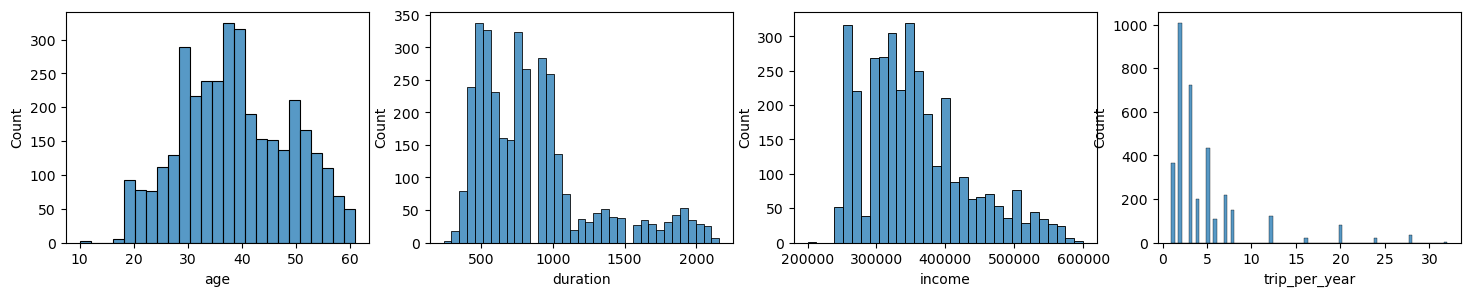

In [95]:
tmp = [
    'age',
    'duration',
    'income',
    'trip_per_year'
]

fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, col in enumerate(tmp):
    sns.histplot(df[col], ax=axes[i])

plt.show()

In [96]:
# 対数変換
df['duration'] = np.log1p(df['duration'])
df['income'] = np.log1p(df['income'])
df['trip_per_year'] = np.log1p(df['trip_per_year'])

X = df.drop('ProdTaken', axis=1)
y = df['ProdTaken']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

s_scaler = StandardScaler()
r_scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['age', 'NumberOfPersonVisiting']] = s_scaler.fit_transform(X_train[['age', 'NumberOfPersonVisiting']])
X_train_scaled[['duration', 'income', 'trip_per_year']] = r_scaler.fit_transform(X_train[['duration', 'income', 'trip_per_year']])

X_test_scaled[['age', 'NumberOfPersonVisiting']] = s_scaler.transform(X_test[['age', 'NumberOfPersonVisiting']])
X_test_scaled[['duration', 'income', 'trip_per_year']] = r_scaler.transform(X_test[['duration', 'income', 'trip_per_year']])

In [97]:
print('Train', X_train_scaled.shape)
print('Test', X_test_scaled.shape)
display(X_train_scaled.head())

Train (2791, 33)
Test (698, 33)


,NumberOfPersonVisiting,Passport,age,duration,follow,trip_per_year,income,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Small Business,...,info_3_2,info_3_3,CityTier_1,CityTier_2,PreferredPropertyStar_3,PreferredPropertyStar_4,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4
3378,-0.553831,0,-1.094799,-0.139127,3,-0.415037,-0.995457,0,0,1,...,0,0,0,1,0,1,0,1,0,0
2100,0.822609,0,0.118778,-1.075514,6,1.000000,1.410269,1,0,0,...,1,0,1,0,1,0,0,0,0,1
3482,0.822609,0,0.321041,-0.639026,4,1.000000,-0.105434,1,0,0,...,0,0,0,1,1,0,0,1,0,0
1908,-0.553831,0,-1.297062,0.000000,3,0.000000,-1.134050,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2599,0.822609,0,0.118778,0.128824,3,1.700440,-0.280697,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [98]:
X_train_scaled.to_csv('data/preprocessed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('data/preprocessed/X_test_scaled.csv', index=False)

In [99]:
y_train.to_csv('data/preprocessed/y_train.csv', index=False)
y_test.to_csv('data/preprocessed/y_test.csv', index=False)

# Test Data Preprocessing

In [100]:
df_submit = pd.read_csv('data/test.csv')

In [101]:
df_submit.shape

(3489, 17)

## Null

In [102]:
# Age -> age

# 日本語をすべてInt型に変換
df_submit["age"] = df_submit["Age"].astype(str).apply(japanese_to_int)

# 欠損値を中央値で補完
# japanese_to_int関数により、欠損値は0と出力されている。
tmp = df_submit[~(df_submit["age"] == 0)]
df_submit.loc[df_submit["age"] == 0, "age"] = tmp["age"].median()

In [103]:
# TypeofContact 後の処理のためにカラム名は変更しない

print(df_submit['TypeofContact'].value_counts())

# 値の数が多い文字列で補完
df_submit['TypeofContact'] = df_submit['TypeofContact'].fillna('Self Enquiry')

TypeofContact
Self Enquiry       2250
Company Invited    1227
Name: count, dtype: int64


In [104]:
# DurationOfPitch -> duration

# 単位をすべて秒に統一
df_submit["duration"] = df_submit["DurationOfPitch"].dropna().apply(convert_to_second)

# 欠損値を中央値で補完
df_submit["duration"] = df_submit["duration"].fillna(df_submit["duration"].median())

In [105]:
# NumberOfFollowups 後の処理のために、カラム名は変更しない

# 欠損値を中央値で補完
df_submit['NumberOfFollowups'] = df_submit['NumberOfFollowups'].fillna(df_submit['NumberOfFollowups'].median())

In [106]:
# NumberOftrips 後の処理のために、カラム名は変更しない

tmp = df_submit[~df_submit['NumberOfTrips'].isna()]
tmp['NumberOfTrips'] = tmp['NumberOfTrips'].apply(normalize_trips)
df_submit['NumberOfTrips'] = df_submit['NumberOfTrips'].fillna(tmp['NumberOfTrips'].median())

C:\Users\ricke\AppData\Local\Temp\ipykernel_16668\3377605089.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['NumberOfTrips'] = tmp['NumberOfTrips'].apply(normalize_trips)


In [107]:
# MonthlyIncome 後の処理のために。カラム名は変更しない

tmp = df_submit[~df_submit['MonthlyIncome'].isna()]
tmp['MonthlyIncome'] = tmp['MonthlyIncome'].apply(normalize_monthly_income)
df_submit['MonthlyIncome'] = df_submit['MonthlyIncome'].fillna(tmp['MonthlyIncome'].median())

C:\Users\ricke\AppData\Local\Temp\ipykernel_16668\820979220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['MonthlyIncome'] = tmp['MonthlyIncome'].apply(normalize_monthly_income)


In [108]:
df_submit.shape

(3489, 19)

In [109]:
df_submit.isna().sum()

id                          0
Age                        93
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
customer_info               0
age                         0
duration                    0
dtype: int64

## Extract Features

In [110]:
df_submit = df_submit.drop(columns=['id', 'Age', 'DurationOfPitch'], axis=1)

In [111]:
df_submit.shape

(3489, 16)

## Normalization

In [112]:
df_submit['gender'] = df_submit['Gender'].apply(normalize_gender)

df_submit['follow'] = df_submit['NumberOfFollowups'].apply(lambda x: x if x < 100 else x / 100)

df_submit['product_pitched'] = df_submit['ProductPitched'].apply(normalize_product_pitched_1)
df_submit['product_pitched'] = df_submit['product_pitched'].apply(normalize_product_pitched_2)

df_submit['trip_per_year'] = df_submit['NumberOfTrips'].apply(normalize_trips)

df_submit['designation'] = df_submit['Designation'].apply(normalize_designation_1)
df_submit['designation'] = df_submit['Designation'].apply(normalize_designation_2)

df_submit['income'] = df_submit['MonthlyIncome'].apply(normalize_monthly_income)

df_submit[['info_1', 'info_2', 'info_3']] = df_submit['customer_info'].apply(divide_customer_info)
df_submit['info_1'] = df_submit['info_1'].apply(normalize_info_1)
df_submit['info_2'] = df_submit['info_2'].apply(normalize_info_2)
df_submit['info_3'] = df_submit['info_3'].apply(normalize_info_3)

In [113]:
df_submit.shape

(3489, 25)

In [114]:
df_submit['trip_per_year'] = df_submit['trip_per_year'].astype('float')
df_submit['trip_per_year'] = df_submit['trip_per_year'].astype('int')

In [115]:
tmp = ["gender", "product_pitched", "trip_per_year", "designation", "info_1", "info_2", "info_3"]
for column in tmp:
    print(column)
    print(df_submit[column].unique(), "\n")

gender
['male' 'female'] 

product_pitched
['Super Deluxe' 'Standard' 'Basic' 'Deluxe' 'King'] 

trip_per_year
[ 7  4  1 24  5  3  2 16  6  8 12 20 28 32] 

designation
['AVP' 'Senior Manager' 'Executive' 'Manager' 'VP'] 

info_1
['Married' 'Divorced' 'Single'] 

info_2
['Has Car' 'No Car'] 

info_3
['0' '1' '2' '3'] 



In [116]:
df_submit = df_submit.drop(columns=['Gender', 'NumberOfFollowups', 'ProductPitched', 'NumberOfTrips', 'Designation', 'customer_info','MonthlyIncome'])

In [117]:
df_submit.shape

(3489, 18)

## Data Type

In [118]:
int_columns = ['NumberOfPersonVisiting', 'PreferredPropertyStar', 'follow']
category_columns = ['TypeofContact', 'Occupation', 'gender', 'product_pitched', 'designation', 'info_1', 'info_2', 'info_3']

for col in int_columns:
    df_submit[col] = df_submit[col].astype('int')

for col in category_columns:
    df_submit[col] = df_submit[col].astype('category')

In [119]:
df_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   TypeofContact           3489 non-null   category
 1   CityTier                3489 non-null   int64   
 2   Occupation              3489 non-null   category
 3   NumberOfPersonVisiting  3489 non-null   int32   
 4   PreferredPropertyStar   3489 non-null   int32   
 5   Passport                3489 non-null   int64   
 6   PitchSatisfactionScore  3489 non-null   int64   
 7   age                     3489 non-null   int64   
 8   duration                3489 non-null   float64 
 9   gender                  3489 non-null   category
 10  follow                  3489 non-null   int32   
 11  product_pitched         3489 non-null   category
 12  trip_per_year           3489 non-null   int32   
 13  designation             3489 non-null   category
 14  income                  

## One-Hot-Encoding

In [120]:
df_submit.shape

(3489, 18)

In [121]:
df_one_hot_encoded = pd.get_dummies(df_submit, dtype=int)
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

36
Index(['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar',
       'Passport', 'PitchSatisfactionScore', 'age', 'duration', 'follow',
       'trip_per_year', 'income', 'TypeofContact_Company Invited',
       'TypeofContact_Self Enquiry', 'Occupation_Large Business',
       'Occupation_Salaried', 'Occupation_Small Business', 'gender_female',
       'gender_male', 'product_pitched_Basic', 'product_pitched_Deluxe',
       'product_pitched_King', 'product_pitched_Standard',
       'product_pitched_Super Deluxe', 'designation_AVP',
       'designation_Executive', 'designation_Manager',
       'designation_Senior Manager', 'designation_VP', 'info_1_Divorced',
       'info_1_Married', 'info_1_Single', 'info_2_Has Car', 'info_2_No Car',
       'info_3_0', 'info_3_1', 'info_3_2', 'info_3_3'],
      dtype='object')


In [122]:
# カテゴリ変数の一部を削除
drop_list = [
    'TypeofContact_Company Invited',  # 「Self Enquiry」を基準とする
    'Occupation_Salaried',  # 他の職業タイプと比較する基準
    'gender_male',  # 「female」を基準とする
    'product_pitched_Basic',  # 他のプロダクトと比較する基準
    'designation_Executive',  # 他の指定と比較する基準
    'info_1_Single',  # 他の婚姻状態と比較する基準
    'info_2_No Car',  # 「Has Car」を基準とする
    'info_3_0'  # 子供の数を比較する基準
]

df_one_hot_encoded = df_one_hot_encoded.drop(columns=drop_list)

In [123]:
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

28
Index(['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar',
       'Passport', 'PitchSatisfactionScore', 'age', 'duration', 'follow',
       'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3'],
      dtype='object')


In [124]:
df_one_hot_encoded.to_csv('data/middle/test_encoded.csv', index=False)

## AGAIN One-Hot-Encoding

In [125]:
df_submit = pd.read_csv('data/middle/test_encoded.csv')

In [126]:
df_submit.shape

(3489, 28)

In [127]:
category_new_list = ['CityTier', 'PreferredPropertyStar', 'PitchSatisfactionScore']

df_one_hot_encoded = pd.get_dummies(df_submit, columns=category_new_list, dtype=int)
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

36
Index(['NumberOfPersonVisiting', 'Passport', 'age', 'duration', 'follow',
       'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'PreferredPropertyStar_3', 'PreferredPropertyStar_4',
       'PreferredPropertyStar_5', 'PitchSatisfactionScore_1',
       'PitchSatisfactionScore_2', 'PitchSatisfactionScore_3',
       'PitchSatisfactionScore_4', 'PitchSatisfactionScore_5'],
      dtype='object')


In [128]:
drop_list = [
    'CityTier_3',
    'PreferredPropertyStar_5',
    'PitchSatisfactionScore_5'
]

df_one_hot_encoded = df_one_hot_encoded.drop(columns=drop_list)

In [129]:
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

33
Index(['NumberOfPersonVisiting', 'Passport', 'age', 'duration', 'follow',
       'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3', 'CityTier_1', 'CityTier_2',
       'PreferredPropertyStar_3', 'PreferredPropertyStar_4',
       'PitchSatisfactionScore_1', 'PitchSatisfactionScore_2',
       'PitchSatisfactionScore_3', 'PitchSatisfactionScore_4'],
      dtype='object')


In [130]:
df_one_hot_encoded.to_csv('data/before_scaled/test_before_scaled.csv', index=False)

## Scaler

In [131]:
df_submit = pd.read_csv('data/before_scaled/test_before_scaled.csv')

In [132]:
df_submit.shape

(3489, 33)

In [133]:
# 対数変換
df_submit['duration'] = np.log1p(df_submit['duration'])
df_submit['income'] = np.log1p(df_submit['income'])
df_submit['trip_per_year'] = np.log1p(df_submit['trip_per_year'])

X = df_submit.copy()
X_scaled = X.copy()

X_scaled[['age', 'NumberOfPersonVisiting']] = s_scaler.transform(X[['age', 'NumberOfPersonVisiting']])
X_scaled[['duration', 'income', 'trip_per_year']] = r_scaler.transform(X[['duration', 'income', 'trip_per_year']])

In [134]:
print(X_scaled.shape)
display(X_scaled.head())

(3489, 33)


,NumberOfPersonVisiting,Passport,age,duration,follow,trip_per_year,income,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Small Business,...,info_3_2,info_3_3,CityTier_1,CityTier_2,PreferredPropertyStar_3,PreferredPropertyStar_4,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4
0,-1.930271,0,0.927829,0.000000,4,1.000000,1.319587,1,0,1,...,0,0,0,1,1,0,0,0,1,0
1,-1.930271,1,-0.892536,-0.139127,4,0.321928,-0.478720,1,0,1,...,0,0,0,1,1,0,0,0,1,0
2,-1.930271,0,-1.398193,-0.639026,4,-1.000000,-0.988598,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,-1.930271,0,-1.802719,-1.075514,4,-1.000000,-0.990311,0,0,0,...,0,0,0,1,0,1,0,0,1,0
4,-1.930271,0,0.219909,-1.075514,4,-1.000000,-0.869600,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [135]:
X_scaled.to_csv('data/preprocessed/X_submission_scaled.csv', index=False)

# Machine Learning Models

In [139]:
X_train_scaled = pd.read_csv('data/preprocessed/X_train_scaled.csv')
X_test_scaled = pd.read_csv('data/preprocessed/X_test_scaled.csv')
y_train = pd.read_csv('data/preprocessed/y_train.csv')
y_test = pd.read_csv('data/preprocessed/y_test.csv')

In [ ]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(2791, 33)
(698, 33)


In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

ProdTaken
0            2393
1             398
Name: count, dtype: int64
ProdTaken
0            599
1             99
Name: count, dtype: int64


## xgboost (Randomized 500times)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    'max_depth': sp_randint(2, 12),
    'learning_rate': uniform(0.01, 0.29),  # 0.01から0.3の範囲
    'subsample': uniform(0.5, 0.5),  # 0.5から1.0の範囲
    'colsample_bytree': uniform(0.5, 0.5),
    'colsample_bylevel': uniform(0.5, 0.5),
    'colsample_bynode': uniform(0.5, 0.5),
    'reg_lambda': uniform(0.0, 10.0),
    'reg_alpha': uniform(0.0, 10.0),
    'gamma': uniform(0.0, 5.0),
    'n_estimators': sp_randint(100, 1000)
}

rand_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=500, scoring='roc_auc', cv=kf, random_state=42)

# フィッティング
rand_search.fit(X_train_scaled, y_train)

# 結果の出力
print("Best score: %f" % rand_search.best_score_)
print("Best parameters: %s" % rand_search.best_params_)

Best score: 0.827681
Best parameters: {'colsample_bylevel': 0.6777465052206787, 'colsample_bynode': 0.8970986656385421, 'colsample_bytree': 0.5464953199115661, 'gamma': 2.9410113347419524, 'learning_rate': 0.14948213806697588, 'max_depth': 4, 'n_estimators': 827, 'reg_alpha': 1.0413735792028744, 'reg_lambda': 2.2543875546369385, 'subsample': 0.8514717204893384}


In [ ]:
best_model = rand_search.best_estimator_

y_pred = rand_search.predict_proba(X_test_scaled)[:, 1]

auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC Score: {auc_score}")

Test AUC Score: 0.8381140284312237


In [ ]:
with open ('model/xgb_randomizedsearch_500.pkl', 'wb') as file:
    pickle.dump(rand_search, file)

## xgboost (second)

In [ ]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')

params = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400]
}

random_search = RandomizedSearchCV(xgb_classifier, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=3, random_state=42, verbose=3)

random_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best AUC found: ", random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 5, 'gamma': 0.0, 'eta': 0.01, 'colsample_bytree': 0.3}
Best AUC found:  0.8130733039858763


In [ ]:
# 最適なモデルを取得
best_model = random_search.best_estimator_

# テストデータでの予測
y_pred = best_model.predict_proba(X_test_scaled)[:, 1]

# AUCの計算
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC Score: {auc_score}")

Test AUC Score: 0.870041531036031


## xgboost

## Gradient Boosting Classifier Randomized 500times

In [143]:
gbc = GradientBoostingClassifier(random_state=42)

parameters = {
    "learning_rate": np.linspace(0.01, 0.5, 100),
    "min_samples_split": np.linspace(0.1, 1.0, 100),
    "min_samples_leaf": np.linspace(0.1, 1.0, 100),
    "max_depth": [3, 5, 7, 9, 11],
    "max_features": ["log2", "sqrt"],
    "subsample": [0.5, 0.6, 0.7 ,0.8, 0.9, 1.0],
    "n_estimators": [100, 200, 300]
}

random_search = RandomizedSearchCV(gbc, param_distributions=parameters, n_iter=500, cv=5, n_jobs=-1, scoring='roc_auc', random_state=42)

random_search.fit(X_train_scaled, y_train)

print("Best parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 0.7545454545454545, 'min_samples_leaf': 0.18181818181818182, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.22777777777777777}
Best ROC AUC Score: 0.8080957678400893


c:\Users\ricke\anaconda3\envs\competition\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ricke\anaconda3\envs\competition\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ricke\anaconda3\envs\competition\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\ricke\anaconda3\envs\competition\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_para

In [144]:
# 最適なモデルを取得
best_model = random_search.best_estimator_

# テストデータでの予測
y_pred = best_model.predict_proba(X_test_scaled)[:, 1]

# AUCの計算
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC Score: {auc_score}")

Test AUC Score: 0.8176253351545506


# 予測

In [145]:
X_submission_scaled = pd.read_csv('data/preprocessed/X_submission_scaled.csv')

In [146]:
X_submission_scaled.shape

(3489, 33)

In [147]:
y_submit = best_model.predict_proba(X_submission_scaled)[:, 1]

# 提出準備

In [148]:
index = pd.read_csv('data/test.csv')['id'].values

df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit.head()

,id,prediction
0,3489,0.165363
1,3490,0.206190
2,3491,0.261524
3,3492,0.428577
4,3493,0.298977


In [149]:
df_submit.to_csv("submission/submit_5.csv", index=False, header=False)

# 提出CSVメモ

1 : 0.8239745 (first xgboost)

2 : 0.8258920 (second xgboost)

3 : 0.8182749

4 : 0.8259785 (xgboost randomized 500times)

5 : 